In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import torch
from torch import optim
from scipy.optimize import least_squares
import time
print("PyTorch version: ", torch.__version__)
current_dir = 'f:/buaa/python/final_proj' 
os.chdir(current_dir) #设置工作目录

PyTorch version:  1.12.1


In [2]:
#visible_debris = pd.read_csv('visible_debris.csv')
visible_debris = pd.read_csv('log_data.csv')
visible_debris['time'] = pd.to_datetime(visible_debris['time'])
visible_debris = visible_debris[visible_debris['category'] == 'debris']
visible_debris = visible_debris.reset_index(drop=True)
fliter_temp = visible_debris['time'] == visible_debris.iloc[50][0]
x = visible_debris[fliter_temp]['x'].values
y = visible_debris[fliter_temp]['y'].values
z = visible_debris[fliter_temp]['z'].values
D = np.array([x,y,z])
n = D.shape[1]

In [3]:
f = 0.01413
dh = 0.000006
dv = 0.000006
H = 700
sensor_attitude = pd.read_csv('data/sensor_attitude.csv')
q = sensor_attitude.iloc[50,1:5].astype(float).values
q = np.array(q)
if q[3]<0:
  q = -q
q0,q1,q2,q3 = q
Msi = np.array([[q3**2+q0**2-q1**2-q2**2, 2*q3*q2+2*q0*q1,     -2*q3*q1+2*q0*q2],
                [-2*q3*q2+2*q0*q1,    q3**2-q0**2+q1**2-q2**2, 2*q3*q0+2*q1*q2],
                [2*q3*q1+2*q0*q2,     -2*q3*q0+2*q1*q2,    q3**2-q0**2-q1**2+q2**2]])
u = visible_debris[fliter_temp]['u'].values
v = visible_debris[fliter_temp]['v'].values
u = (H-u)*dh 
v = (H-v)*dv 
f0 = np.ones(len(u))*f 
W = np.array([-v,-u,f0]) #试出来就是这样，我有什么办法捏
w = np.linalg.norm(W,axis=0)#求W的每列的模长
W = W/w#将W的每列单位化
print(W.shape)

(3, 4)


In [4]:
sensor = pd.read_csv('data/mysenior_sensor_data_output.csv')
A0 = sensor.iloc[50,1:4].astype(float).values
# least_square
def my_fun(x):
  x = x.reshape(3,1)
  A = np.tile(x,n)
  V = D - A
  V_scaled = V/np.linalg.norm(V,axis=0)
  Lv = Msi@V_scaled
  return np.mean((Lv[:2]-W[:2])**2)

x0 = A0+np.random.normal(0,200,3)
res = least_squares(my_fun, x0, jac='3-point', loss='arctan')
print(A0)
print(res.x)
print("error: ", np.linalg.norm(res.x-A0))
print(res)

[-1287.984516  6322.765067 -2046.641477]
[ 3121.37761137 10238.22882652 -1801.33905046]
error:  5901.991537005839
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 1.415e-02]
           x: [ 3.121e+03  1.024e+04 -1.801e+03]
        cost: 0.00010008149258319166
         jac: [[-5.259e-07 -4.481e-07  2.011e-07]]
        grad: [-7.440e-09 -6.340e-09  2.845e-09]
  optimality: 7.439841991875564e-09
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 9
        njev: 6


In [6]:
sensor = pd.read_csv('data/mysenior_sensor_data_output.csv')
A0 = sensor.iloc[50,1:4].astype(float).values
A_true = np.matrix(A0).T
print('True A:',A0)
A0 = np.matrix(A0+np.random.normal(0,30,3)).T
A0_noise = A0
print('A with noise:',A0.T)
A0 = torch.tensor(A0,requires_grad=True)

True A: [-1287.984516  6322.765067 -2046.641477]
A with noise: [[-1255.54495673  6324.37212183 -2046.17892483]]


In [ ]:
# TORCH
D = torch.tensor(D)
print(D.shape)
Msi = torch.tensor(Msi)
W = torch.tensor(W)
A0 = torch.tensor(A0_noise, requires_grad=True)

optimizer = optim.Adam([A0], lr=0.01)
epsilon = 1e-6
A_log = []
loss_log = []
grad_log = []
print(A_true.tolist())
print(A0_noise.tolist())
# 迭代优化
time0 = time.time()
for epoch in range(20000):
    optimizer.zero_grad()

    V = D - A0.repeat(1, n)
    V_scaled = torch.nn.functional.normalize(V, dim=0)
    Lv = Msi@V_scaled
    loss = torch.nn.functional.mse_loss(Lv, W)

    # 反向传播
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, A0: {A0.detach().numpy().tolist()}")
        grad_log.append(A0.grad.detach().numpy().tolist())
        A_log.append(A0.detach().numpy().tolist())
        loss_log.append(loss.item())
time1 = time.time()
# 输出结果
print("Optimized A0:", A0.detach().numpy().tolist())

C:\Users\clyde\AppData\Local\Temp\ipykernel_26072\729090196.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(D)
C:\Users\clyde\AppData\Local\Temp\ipykernel_26072\729090196.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Msi = torch.tensor(Msi)
C:\Users\clyde\AppData\Local\Temp\ipykernel_26072\729090196.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W)


torch.Size([3, 4])
[[-1287.984516], [6322.765067], [-2046.641477]]
[[-1255.5449567290634], [6324.372121828463], [-2046.1789248334978]]
Epoch 0, Loss: 0.0619, A0: [[-1255.5349623503685], [6324.382119968091], [-2046.1889229822639]]
Epoch 500, Loss: 0.0612, A0: [[-1250.5604986684302], [6329.373420619614], [-2051.181100278289]]
Epoch 1000, Loss: 0.0606, A0: [[-1245.629558688325], [6334.349920344196], [-2056.160069998075]]
Epoch 1500, Loss: 0.0600, A0: [[-1240.7345878061763], [6339.314338409761], [-2061.1281512176256]]
Epoch 2000, Loss: 0.0594, A0: [[-1235.8687707696563], [6344.269144515394], [-2066.0874559143476]]
Epoch 2500, Loss: 0.0588, A0: [[-1231.0262337931174], [6349.216474102011], [-2071.039813100802]]
Epoch 3000, Loss: 0.0582, A0: [[-1226.2020960575348], [6354.158102295415], [-2075.9867443488]]
Epoch 3500, Loss: 0.0576, A0: [[-1221.392438155902], [6359.095452630548], [-2080.9294698357676]]
Epoch 4000, Loss: 0.0571, A0: [[-1216.5942109229857], [6364.029630602307], [-2085.86893631464

In [8]:
print("error: ", (A0.detach().numpy()-A_true).T, np.linalg.norm(A0.detach().numpy()-A_true))
print("time: ", time1-time0)

error:  [[ 222.00380355  198.80655927 -196.66966027]] 357.0555868117858
time:  6.522111892700195


In [30]:
loss_log = pd.DataFrame(loss_log)
A_log = pd.DataFrame(A_log)
loss_log.to_csv('loss_log.csv')
A_log.to_csv('A_log.csv')

AttributeError: 'list' object has no attribute 'tolist'

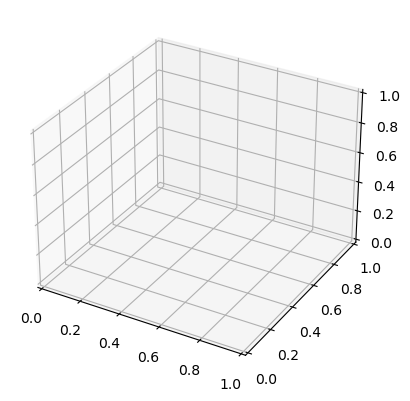

In [9]:
# 绘制A_log的3D散点图，通过颜色变化来表示先后顺序
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = A_log[0].tolist()
y = A_log[1].tolist()
z = A_log[2].tolist()
c = np.arange(len(x))
scatter = ax.scatter(x, y, z, c=c, cmap='coolwarm')
# scatter = ax.scatter(A_true[0], A_true[1], A_true[2], marker='x')
plt.colorbar(scatter)

ax.scatter(
    [A_true[0]], [A_true[1]], [A_true[2]],  # 坐标（必须传入列表）
    color='black',               # 颜色设为亮金色
    marker='*',                 # 形状设为星号
    s=200,                      # 大小设为 200
    edgecolors='black',         # 边框颜色设为黑色
    linewidths=1,               # 边框宽度
    label='Aircraft'   # 图例标签
)
plt.title('Aircraft position optimization')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Loss curve')

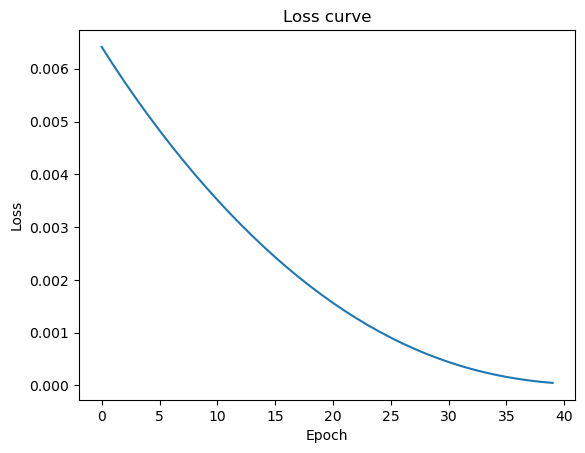

In [11]:
plt.plot(loss_log)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')

In [ ]:
# 手动算梯度的，梯度算出来不对劲
def my_loss_fun(W, Msi, D, A0):
  epsilon = 1e-6
  A = np.array(A0.repeat(n, axis=1))
  V = D - A
  s = np.sum(V**2, axis=0) + epsilon
  sqrt_s = np.sqrt(s)
  V_scaled = V / sqrt_s
  LV = Msi @ V_scaled
  return np.sum((W - LV)**2)

print(my_loss_fun(W, Msi, D, A_true))

def my_gradient(W, Msi, D, A0,n):
  A = np.array(A0.repeat(n, axis=1))
  V = D - A
  s = np.sum(V**2, axis=0)+1e-6
  sqrt_s = np.sqrt(s)
  e = W-Msi@V/sqrt_s
  grad = np.zeros((3,1))
  for i in range(n):
    p1 = np.eye(3)/sqrt_s[i]
    p2 = -np.outer(V[:,i],V[:,i])/sqrt_s[i]**3
    p = p1+p2
    e_i = np.matrix(e[:,i]).T
    grad += (2*Msi@p@e_i)
  return grad/np.linalg.norm(grad)
# print(my_loss_fun(W, Msi, D, A0_noise))
# print(my_gradient(W, Msi, D, A0_noise,n))
# print(np.array(A_true.tolist())-np.array(A0_noise.tolist()))

# 纯几何天文定位

In [6]:
#自己写的
import numpy as np
import pandas as pd 


def least_squares(A, b):
    # 使用SVD分解求解最小二乘问题
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    L_flat = Vt.T @ np.diag(1/s) @ U.T @ b
    return L_flat

def get_direction_vector(time0,debris,star):
    debris  = debris[debris['time'] == time0]
    star = star[star['time'] == time0]
    n_debris = debris.shape[0]
    n_star = star.shape[0]
    L = []
    R = []
    for i in range(n_debris):
        S = []
        cos = []
        debris_u, debris_v = debris.iloc[i][['u','v']].astype(float).values
        debris_uv = np.array([(debris_u)*0.000006,(debris_v)*0.000006,0.01413])
        debris_vec = debris.iloc[i][['x','y','z']].astype(float).values
        for j in range(n_star):
            star_vec = star.iloc[j][['x','y','z']].astype(float).values
            star_vec = np.array(star_vec)
            star_u, star_v = star.iloc[j][['u','v']].astype(float).values
            star_uv = np.array([(star_u)*0.000006,(star_v)*0.000006,0.01413])
            cos_angle = np.dot(star_uv,debris_uv)/(np.linalg.norm(star_uv)*np.linalg.norm(debris_uv))
            # print(star_uv,debris_uv,cos_angle)
            S.append(star_vec)
            cos.append(cos_angle)
        L0 = least_squares(np.array(S),np.array(cos))
        # print(S)
        L.append(L0)
        R.append(debris_vec)
    return np.array(L),np.array(R)

visible_star = pd.read_csv('log_data.csv')
visible_star['time'] = pd.to_datetime(visible_star['time'])
visible_star = visible_star[visible_star['category'] == 'star']
star = visible_star.reset_index(drop=True)
# visible_debris = pd.read_csv('visible_debris.csv')
# visible_debris['time'] = pd.to_datetime(visible_debris['time'])
visible_debris = pd.read_csv('log_data.csv')
visible_debris['time'] = pd.to_datetime(visible_debris['time'])
visible_debris = visible_debris[visible_debris['category'] == 'debris']
debris = visible_debris.reset_index(drop=True)
L, R = get_direction_vector(time0=debris.iloc[50][0],debris=debris,star=star)
print(L,R)
print(debris.iloc[50][0])

[[-0.85139854 -0.26031519 -0.45536409]
 [-0.83058964 -0.39896417 -0.38852356]
 [-0.6947874  -0.54284224 -0.47179375]
 [-0.69986935 -0.27056099 -0.6610456 ]] [[-4386.470195  5378.567102 -3698.099428]
 [-4314.667802  4868.391003 -3455.694157]
 [-4029.291207  4173.586909 -3906.170484]
 [-2777.584497  5748.498772 -3456.575055]]
2023-04-25 16:00:01.200000


In [3]:
def get_Ac(n,L):
    matrix = np.zeros((int(3*n*(n-1)/2),n))
    count = 0
    for i in range(n):
        for j in range(i+1, n):
            matrix[3*count:3*count+3,i] = list(L[i])
            matrix[3*count:3*count+3,j] = [-x for x in L[j]]
            count += 1
    return matrix
def get_delta_R(n,R):
    matrix = np.zeros((int(3*n*(n-1)/2)))
    count = 0
    for i in range(n):
        for j in range(i+1, n):
            matrix[3*count:3*count+3] = R[j]-R[i]
            count += 1
    return matrix
def get_position(R,L,rho):
    position = []
    for i in range(len(R)):
        position.append(R[i]+rho[i]*L[i])
    return np.array(position)

In [8]:
n = L.shape[0]
Ac = get_Ac(n,L)
delta_R = get_delta_R(n,R)
rho = least_squares(Ac,delta_R)
position = get_position(R,L,rho)
print(position)
print(position.mean(axis=0))
#[[-1287.984516], [6322.765067], [-2046.641477]]
position0 = np.array([-1266.600454,  6332.634164, -2029.443145])
error = np.linalg.norm(position0-position.mean(axis=0))
print(error)

[[-1266.66102829  6332.44906989 -2029.49302013]
 [-1266.51119894  6332.53792517 -2029.86292145]
 [-1266.28358596  6332.3440408  -2029.9566808 ]
 [-1266.74585714  6332.57063387 -2029.54694545]]
[-1266.55041758  6332.47541744 -2029.71489196]
0.31866993023241513


In [ ]:
## Block-CNS
import cns
import pandas as pd 
import numpy as np 
start = 0
end = 5999

visible_star = pd.read_csv('F:\\buaa\\python\\final_proj\\log_data.csv')
visible_star['time'] = pd.to_datetime(visible_star['time'])
visible_star = visible_star[visible_star['category'] == 'star']
star = visible_star.reset_index(drop=True)
# visible_debris = pd.read_csv('visible_debris.csv')
# visible_debris['time'] = pd.to_datetime(visible_debris['time'])
visible_debris = pd.read_csv('F:\\buaa\\python\\final_proj\\log_data.csv')
visible_debris['time'] = pd.to_datetime(visible_debris['time'])
visible_debris = visible_debris[visible_debris['category'] == 'debris']
debris = visible_debris.reset_index(drop=True)
time_list = visible_star['time'].unique()[start:end]
df = cns.cns_main(star,debris, time_list)


2023-04-25T16:00:00.000000000
2023-04-25T16:00:00.100000000
2023-04-25T16:00:00.200000000
2023-04-25T16:00:00.300000000
2023-04-25T16:00:00.400000000
2023-04-25T16:00:00.500000000
2023-04-25T16:00:00.600000000
2023-04-25T16:00:00.700000000
2023-04-25T16:00:00.800000000
2023-04-25T16:00:00.900000000
2023-04-25T16:00:01.000000000
2023-04-25T16:00:01.100000000
2023-04-25T16:00:01.200000000
2023-04-25T16:00:01.300000000
2023-04-25T16:00:01.400000000
2023-04-25T16:00:01.500000000
2023-04-25T16:00:01.600000000
2023-04-25T16:00:01.700000000
2023-04-25T16:00:01.800000000
2023-04-25T16:00:01.900000000
2023-04-25T16:00:02.000000000
2023-04-25T16:00:02.100000000
2023-04-25T16:00:02.200000000
2023-04-25T16:00:02.300000000
2023-04-25T16:00:02.400000000
2023-04-25T16:00:02.500000000
2023-04-25T16:00:02.600000000
2023-04-25T16:00:02.700000000
2023-04-25T16:00:02.800000000
2023-04-25T16:00:02.900000000
2023-04-25T16:00:03.000000000
2023-04-25T16:00:03.100000000
2023-04-25T16:00:03.200000000
2023-04-25

In [6]:
import matplotlib.pyplot as plt
sensor_data = pd.read_csv('data/mysenior_sensor_data_output.csv')
sensor_data['Time (UTCG)'] = pd.to_datetime(sensor_data['Time (UTCG)'])
sat_data = pd.read_csv('data/Satellite1.csv')

cns_pos = np.array(df.iloc[:,1:4].values)
cns_q = np.array(df.iloc[:][['q0','q1','q2','q3']])

true_pos = np.array(sensor_data.iloc[start:end,1:4].values)
true_q = np.array(sat_data.iloc[start:end][['q1','q2','q3','q4']])
for i in range(len(true_q)):
    if true_q[i][3]<0:
        true_q[i] = -true_q[i]

delta_pos = cns_pos - true_pos
delta_q = cns_q - true_q

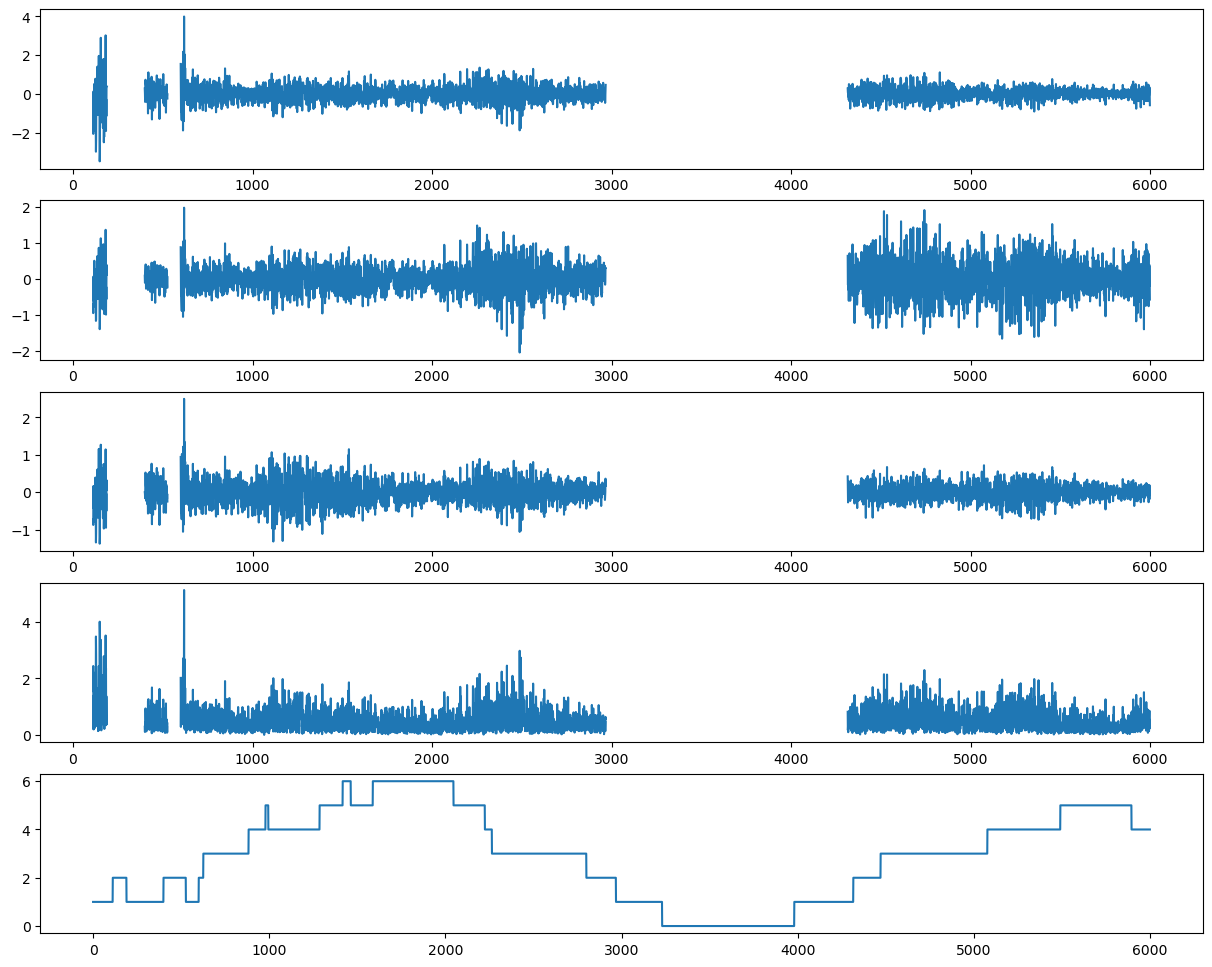

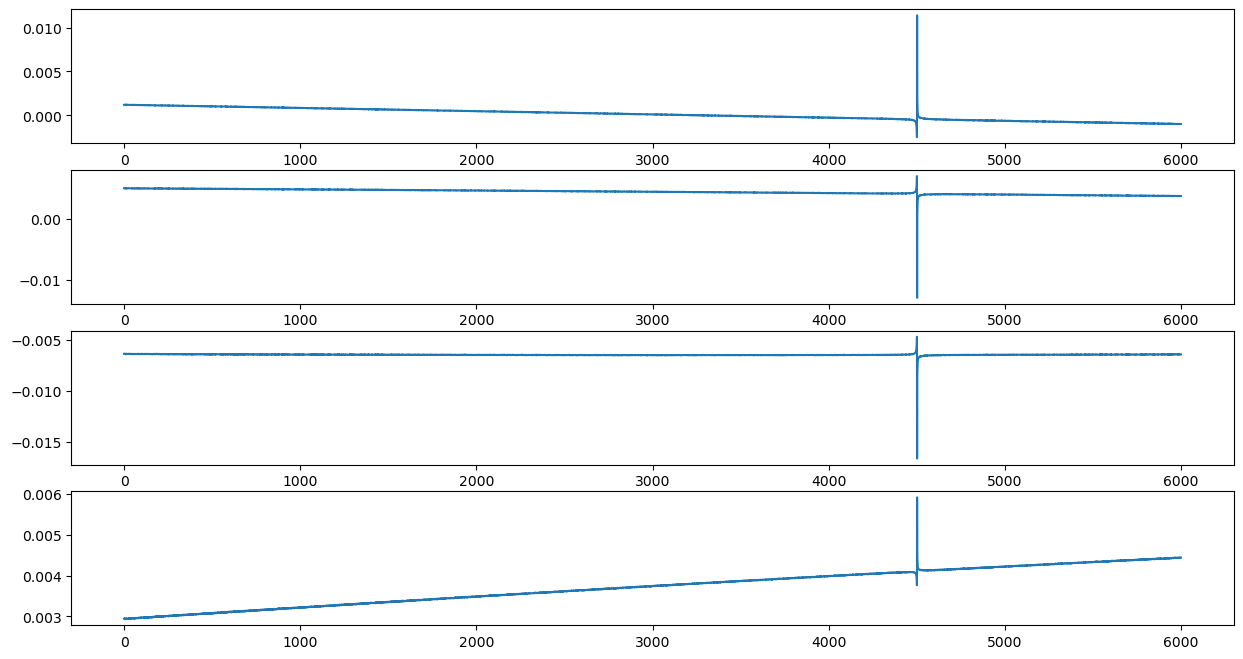

In [7]:
plt_start = 0
plt_end = end-start
x_range = range(plt_start, plt_end)
# print(time_list[plt_start],time_list[plt_end])

plt.figure(figsize=(15, 12))
plt.subplot(5, 1, 1)
plt.plot(x_range, delta_pos[plt_start:plt_end, 0], label='X Position Error')
plt.subplot(5, 1, 2)
plt.plot(x_range, delta_pos[plt_start:plt_end, 1], label='Y Position Error')
plt.subplot(5, 1, 3)
plt.plot(x_range, delta_pos[plt_start:plt_end, 2], label='Z Position Error')
plt.subplot(5, 1, 4)
plt.plot(x_range, np.linalg.norm(delta_pos[plt_start:plt_end],axis=1), label='Position Error')
plt.subplot(5, 1, 5)
plt.plot(x_range, df['n_debris'][plt_start:plt_end], label='Number of Debris')

plt.figure(figsize=(15, 8))
plt.subplot(4, 1, 1)
plt.plot(x_range, delta_q[plt_start:plt_end, 0], label='q1 Error')
plt.subplot(4, 1, 2)
plt.plot(x_range, delta_q[plt_start:plt_end, 1], label='q2 Error')
plt.subplot(4, 1, 3)
plt.plot(x_range, delta_q[plt_start:plt_end, 2], label='q3 Error')
plt.subplot(4, 1, 4)
plt.plot(x_range, delta_q[plt_start:plt_end, 3], label='q4 Error')
plt.show()


In [29]:
print(cns_q[4498:4505])
print(true_q[4498:4505])
def get_attitude_angle_from_q(q):
  q0, q1, q2, q3 = q
  phi = np.arcsin(2*(q0*q1+q2*q3))
  psi = -np.arctan2(2*(q1*q3-q0*q2), q0**2-q1**2-q2**2+q3**2)
  gamma = -np.arctan2(2*(-q0*q3+q1*q2), q0**2-q1**2+q2**2-q3**2)
  return np.array([phi,psi,gamma])

[[-0.48852761 -0.66793474  0.56142948  0.00094455]
 [-0.48814399 -0.66817201  0.56148032  0.00120719]
 [-0.48616505 -0.66948087  0.56163238  0.00282543]
 [ 0.50133908  0.65905027 -0.56054201  0.0102231 ]
 [ 0.49250874  0.66514794 -0.56125399  0.00270541]
 [ 0.49076941  0.6663114  -0.56140258  0.00128555]
 [ 0.4902135   0.66666809 -0.5614656   0.00087487]]
[[-4.89507e-01 -6.67275e-01  5.61361e-01  1.14000e-04]
 [-4.89475e-01 -6.67275e-01  5.61389e-01  7.70000e-05]
 [-4.89443e-01 -6.67275e-01  5.61417e-01  3.90000e-05]
 [-4.89412e-01 -6.67275e-01  5.61445e-01  1.00000e-06]
 [ 4.89380e-01  6.67275e-01 -5.61472e-01  3.70000e-05]
 [ 4.89348e-01  6.67275e-01 -5.61500e-01  7.50000e-05]
 [ 4.89316e-01  6.67275e-01 -5.61528e-01  1.13000e-04]]


In [8]:
df.to_csv('cns.csv')